# CNN + MaxPool
Same as CNN_265, which used cell line H1.hESC only.
It did very well.
Is that because H1.hESC has more expressed genes than any other cell line?
Here, reduce that effect by using 20:80 instead of 80:20.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-28 11:45:25.355459


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = {x for x in range(NUM_CELL_LINES) if x!=1}   # exclude all but H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-28 11:45:56.296298
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 64)          2112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1246, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1246, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 308, 64)          0         
 1D)                         

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            # ad-hoc approach to using fewer test genes:
            # flip the roles of train and valid, 
            # so 80:20 becomes 20:80
            # if gene_id in self.val_genes:
            if gene_id not in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-28 11:45:56.677819
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 3774
Num RCI: 3774
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 3774 sequences.
2023-03-28 11:46:03.949785

Training # 1 1
2023-03-28 11:46:03.949987
2023-03-28 11:46:03.950041
Discriminator ZERO -1
Train 1:0 488:255 65.68%
Computed class weights: {0: 1.4568627450980391, 1: 0.7612704918032787}
Valid 1:0 1911:1120 63.05%
FIT
2023-03-28 11:46:05.917521


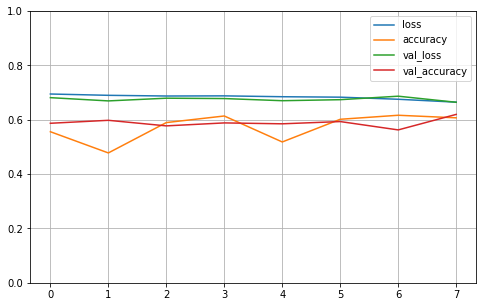


2023-03-28 11:46:28.000883

Testing # 1 1
2023-03-28 11:46:28.001402
2023-03-28 11:46:28.001694
PREDICT
2023-03-28 11:46:28.797443
Test 1:0 1911:1120 63.05%
Predict 1:0 2500:531 82.48%
Test sizes (3031, 4997) (3031,)
Range of scores: 0.26933503 to 0.7023569
Score threshold 0.5
Confusion matrix
 [[ 249  871]
 [ 282 1629]]
Normalized matrix
 [[0.08215111 0.28736391]
 [0.0930386  0.53744639]]


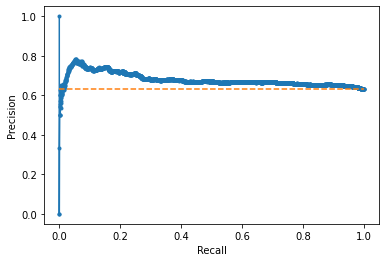

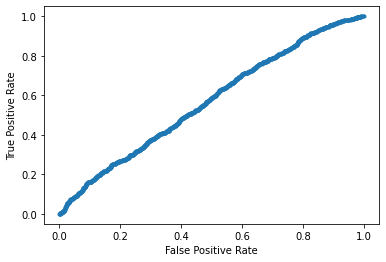

Accuracy: 61.96% Precision: 65.16% Recall: 85.24%
F1: 73.86% MCC: 0.0949
AUPRC: 67.92% AUROC: 56.91%
 accuracy [61.95974925767074]
 precision [65.16]
 recall [85.24332810047096]
 F1 [73.86080253910677]
 MCC [0.09492063798767283]
 AUPRC [67.91665252696622]
 AUROC [56.910345182028856]
2023-03-28 11:46:30.371159

Training # 1 2
2023-03-28 11:46:30.371360
2023-03-28 11:46:30.371409
Discriminator ZERO -1
Train 1:0 485:277 63.65%
Computed class weights: {0: 1.3754512635379061, 1: 0.7855670103092783}
Valid 1:0 1914:1098 63.55%
FIT
2023-03-28 11:46:32.328379


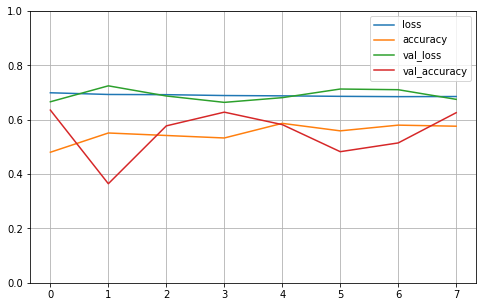


2023-03-28 11:46:41.562150

Testing # 1 2
2023-03-28 11:46:41.562587
2023-03-28 11:46:41.562623
PREDICT
2023-03-28 11:46:42.336837
Test 1:0 1914:1098 63.55%
Predict 1:0 2481:531 82.37%
Test sizes (3012, 4997) (3012,)
Range of scores: 0.35968778 to 0.6815212
Score threshold 0.5
Confusion matrix
 [[ 251  847]
 [ 280 1634]]
Normalized matrix
 [[0.08333333 0.2812085 ]
 [0.09296149 0.54249668]]


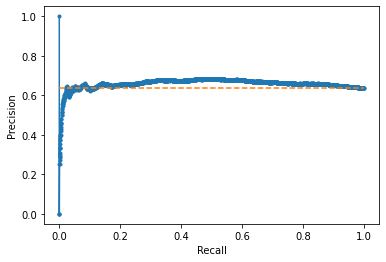

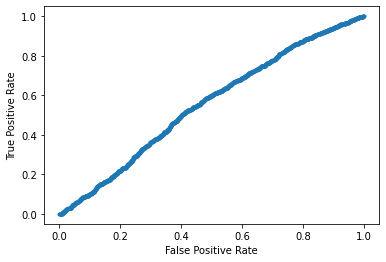

Accuracy: 62.58% Precision: 65.86% Recall: 85.37%
F1: 74.36% MCC: 0.1040
AUPRC: 65.81% AUROC: 55.51%
 accuracy [62.58300132802125]
 precision [65.86054010479646]
 recall [85.37095088819227]
 F1 [74.35722411831627]
 MCC [0.10395563822814884]
 AUPRC [65.81410432529475]
 AUROC [55.51230221948141]
2023-03-28 11:46:43.934589

Training # 1 3
2023-03-28 11:46:43.936856
2023-03-28 11:46:43.937211
Discriminator ZERO -1
Train 1:0 474:269 63.80%
Computed class weights: {0: 1.3810408921933086, 1: 0.7837552742616034}
Valid 1:0 1925:1106 63.51%
FIT
2023-03-28 11:46:45.875014


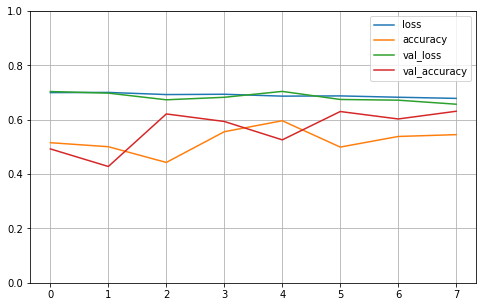


2023-03-28 11:46:55.492633

Testing # 1 3
2023-03-28 11:46:55.493049
2023-03-28 11:46:55.493090
PREDICT
2023-03-28 11:46:56.297148
Test 1:0 1925:1106 63.51%
Predict 1:0 2615:416 86.28%
Test sizes (3031, 4997) (3031,)
Range of scores: 0.31466094 to 0.6598942
Score threshold 0.5
Confusion matrix
 [[ 202  904]
 [ 214 1711]]
Normalized matrix
 [[0.06664467 0.2982514 ]
 [0.07060376 0.56450016]]


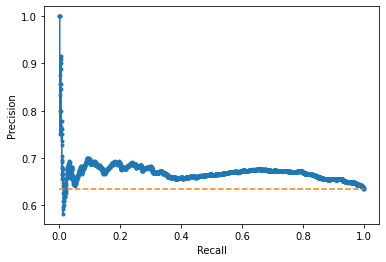

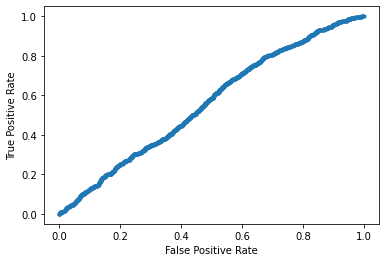

Accuracy: 63.11% Precision: 65.43% Recall: 88.88%
F1: 75.37% MCC: 0.1000
AUPRC: 66.97% AUROC: 56.06%
 accuracy [63.11448366875618]
 precision [65.4302103250478]
 recall [88.88311688311688]
 F1 [75.37444933920705]
 MCC [0.0999866878251752]
 AUPRC [66.97029921906945]
 AUROC [56.06411310208779]
2023-03-28 11:46:57.954646

Training # 1 4
2023-03-28 11:46:57.956724
2023-03-28 11:46:57.957150
Discriminator ZERO -1
Train 1:0 460:288 61.50%
Computed class weights: {0: 1.2986111111111112, 1: 0.8130434782608695}
Valid 1:0 1939:1087 64.08%
FIT
2023-03-28 11:46:59.871631


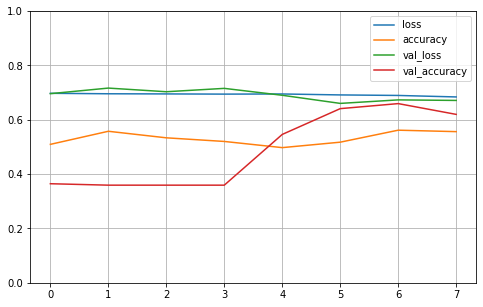


2023-03-28 11:47:11.373098

Testing # 1 4
2023-03-28 11:47:11.374617
2023-03-28 11:47:11.375000
PREDICT
2023-03-28 11:47:12.829934
Test 1:0 1939:1087 64.08%
Predict 1:0 2174:852 71.84%
Test sizes (3026, 4997) (3026,)
Range of scores: 0.38544542 to 0.60114795
Score threshold 0.5
Confusion matrix
 [[ 394  693]
 [ 458 1481]]
Normalized matrix
 [[0.13020489 0.2290152 ]
 [0.15135492 0.48942498]]


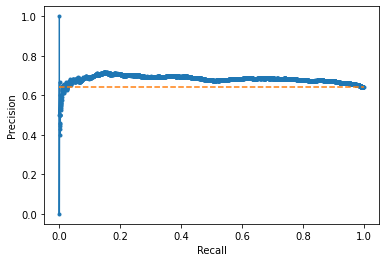

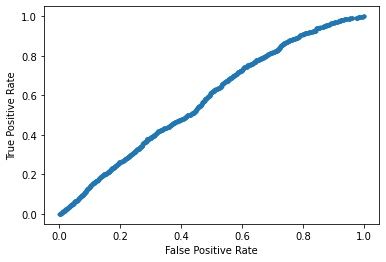

Accuracy: 61.96% Precision: 68.12% Recall: 76.38%
F1: 72.02% MCC: 0.1347
AUPRC: 68.26% AUROC: 57.87%
 accuracy [61.962987442167886]
 precision [68.12327506899723]
 recall [76.37957710159876]
 F1 [72.01556041818624]
 MCC [0.13468656313084457]
 AUPRC [68.25527886671868]
 AUROC [57.86834230601895]
2023-03-28 11:47:14.363417

Training # 1 5
2023-03-28 11:47:14.363579
2023-03-28 11:47:14.363630
Discriminator ZERO -1
Train 1:0 492:286 63.24%
Computed class weights: {0: 1.3601398601398602, 1: 0.790650406504065}
Valid 1:0 1907:1089 63.65%
FIT
2023-03-28 11:47:15.398787


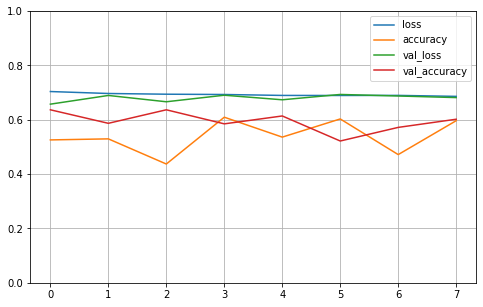


2023-03-28 11:47:24.366091

Testing # 1 5
2023-03-28 11:47:24.370832
2023-03-28 11:47:24.371184
PREDICT
2023-03-28 11:47:25.817440
Test 1:0 1907:1089 63.65%
Predict 1:0 2190:806 73.10%
Test sizes (2996, 4997) (2996,)
Range of scores: 0.37304595 to 0.5692687
Score threshold 0.5
Confusion matrix
 [[ 351  738]
 [ 455 1452]]
Normalized matrix
 [[0.11715621 0.24632844]
 [0.15186916 0.48464619]]


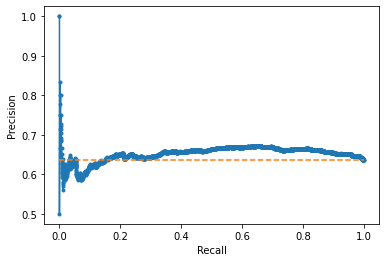

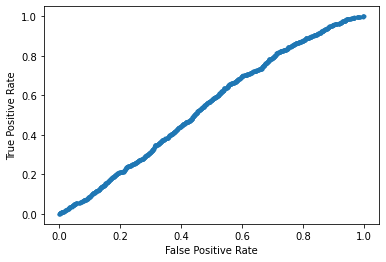

Accuracy: 60.18% Precision: 66.30% Recall: 76.14%
F1: 70.88% MCC: 0.0908
AUPRC: 65.24% AUROC: 54.49%
 accuracy [60.18024032042724]
 precision [66.3013698630137]
 recall [76.14053487152596]
 F1 [70.88113253600196]
 MCC [0.09080835457680851]
 AUPRC [65.24043550246653]
 AUROC [54.494027369080996]
2023-03-28 11:47:27.266209

Training # 2 1
2023-03-28 11:47:27.267230
2023-03-28 11:47:27.267279
Discriminator ZERO -1
Train 1:0 487:264 64.85%
Computed class weights: {0: 1.4223484848484849, 1: 0.771047227926078}
Valid 1:0 1912:1111 63.25%
FIT
2023-03-28 11:47:28.358013


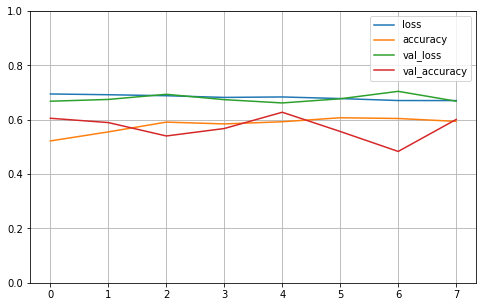


2023-03-28 11:47:39.699306

Testing # 2 1
2023-03-28 11:47:39.699390
2023-03-28 11:47:39.699424
PREDICT
2023-03-28 11:47:40.470660
Test 1:0 1912:1111 63.25%
Predict 1:0 2158:865 71.39%
Test sizes (3023, 4997) (3023,)
Range of scores: 0.28612545 to 0.70713913
Score threshold 0.5
Confusion matrix
 [[ 385  726]
 [ 480 1432]]
Normalized matrix
 [[0.12735693 0.24015878]
 [0.15878267 0.47370162]]


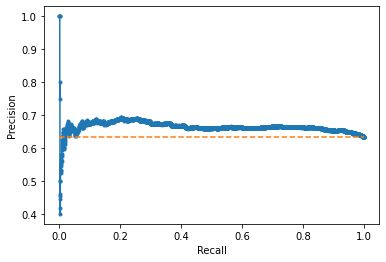

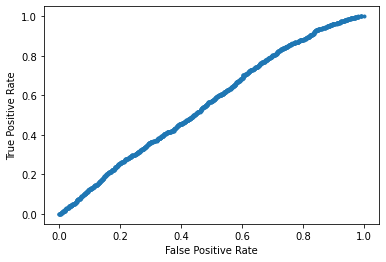

Accuracy: 60.11% Precision: 66.36% Recall: 74.90%
F1: 70.37% MCC: 0.1019
AUPRC: 66.51% AUROC: 55.93%
 accuracy [60.105855110817075]
 precision [66.35773864689527]
 recall [74.89539748953975]
 F1 [70.36855036855036]
 MCC [0.10186356103020958]
 AUPRC [66.50567345258901]
 AUROC [55.92920170678155]
2023-03-28 11:47:41.818521

Training # 2 2
2023-03-28 11:47:41.818670
2023-03-28 11:47:41.818716
Discriminator ZERO -1
Train 1:0 477:269 63.94%
Computed class weights: {0: 1.3866171003717471, 1: 0.7819706498951782}
Valid 1:0 1922:1106 63.47%
FIT
2023-03-28 11:47:43.880616


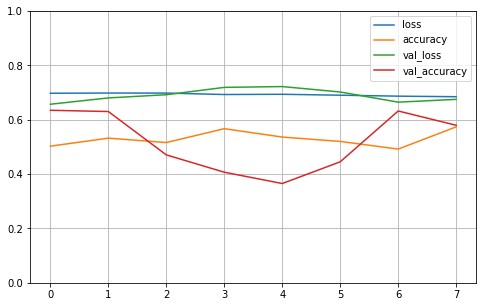


2023-03-28 11:47:55.217054

Testing # 2 2
2023-03-28 11:47:55.217272
2023-03-28 11:47:55.217315
PREDICT
2023-03-28 11:47:55.986914
Test 1:0 1922:1106 63.47%
Predict 1:0 2237:791 73.88%
Test sizes (3028, 4997) (3028,)
Range of scores: 0.41430184 to 0.7302297
Score threshold 0.5
Confusion matrix
 [[ 312  794]
 [ 479 1443]]
Normalized matrix
 [[0.10303831 0.26221929]
 [0.15819022 0.47655218]]


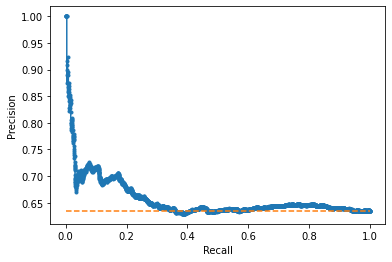

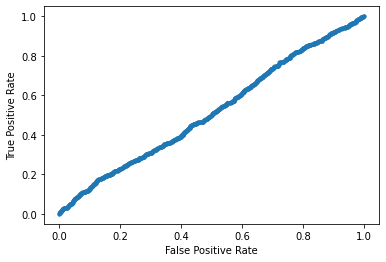

Accuracy: 57.96% Precision: 64.51% Recall: 75.08%
F1: 69.39% MCC: 0.0360
AUPRC: 65.78% AUROC: 51.74%
 accuracy [57.959048877146635]
 precision [64.50603486812696]
 recall [75.07804370447451]
 F1 [69.39168069247415]
 MCC [0.036036246711551596]
 AUPRC [65.77839585707761]
 AUROC [51.74262324695682]
2023-03-28 11:47:57.327728

Training # 2 3
2023-03-28 11:47:57.328566
2023-03-28 11:47:57.328620
Discriminator ZERO -1
Train 1:0 484:279 63.43%
Computed class weights: {0: 1.3673835125448028, 1: 0.7882231404958677}
Valid 1:0 1915:1096 63.60%
FIT
2023-03-28 11:47:58.398964


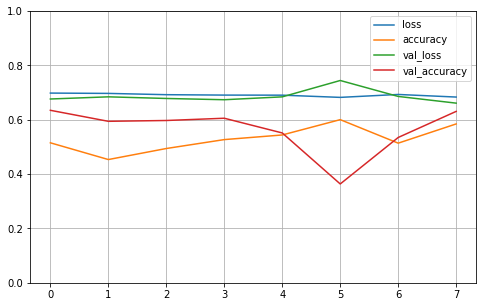


2023-03-28 11:48:08.006366

Testing # 2 3
2023-03-28 11:48:08.006488
2023-03-28 11:48:08.006522
PREDICT
2023-03-28 11:48:08.775937
Test 1:0 1915:1096 63.60%
Predict 1:0 2913:98 96.75%
Test sizes (3011, 4997) (3011,)
Range of scores: 0.4603412 to 0.6892697
Score threshold 0.5
Confusion matrix
 [[  41 1055]
 [  57 1858]]
Normalized matrix
 [[0.01361674 0.35038193]
 [0.01893059 0.61707074]]


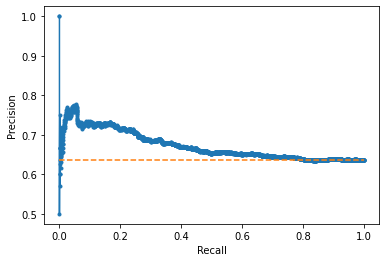

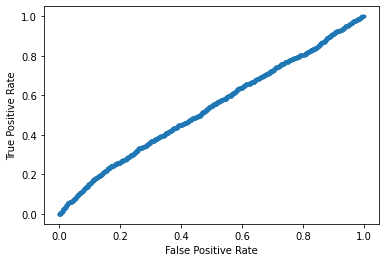

Accuracy: 63.07% Precision: 63.78% Recall: 97.02%
F1: 76.97% MCC: 0.0207
AUPRC: 67.24% AUROC: 53.54%
 accuracy [63.068747924277645]
 precision [63.78304153793341]
 recall [97.02349869451697]
 F1 [76.96768848384424]
 MCC [0.020725863668858435]
 AUPRC [67.24319013892972]
 AUROC [53.53719197270873]
2023-03-28 11:48:10.248835

Training # 2 4
2023-03-28 11:48:10.249640
2023-03-28 11:48:10.250884
Discriminator ZERO -1
Train 1:0 464:282 62.20%
Computed class weights: {0: 1.322695035460993, 1: 0.8038793103448276}
Valid 1:0 1935:1093 63.90%
FIT
2023-03-28 11:48:11.300902


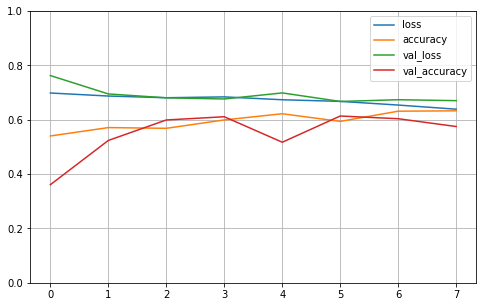


2023-03-28 11:48:22.656111

Testing # 2 4
2023-03-28 11:48:22.656519
2023-03-28 11:48:22.656552
PREDICT
2023-03-28 11:48:23.443779
Test 1:0 1935:1093 63.90%
Predict 1:0 1862:1166 61.49%
Test sizes (3028, 4997) (3028,)
Range of scores: 0.18291049 to 0.8429849
Score threshold 0.5
Confusion matrix
 [[ 486  607]
 [ 680 1255]]
Normalized matrix
 [[0.16050198 0.20046235]
 [0.22457067 0.41446499]]


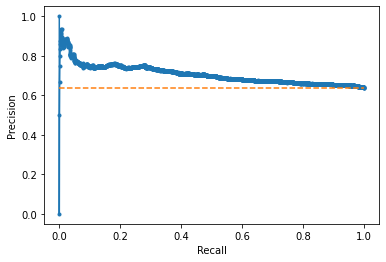

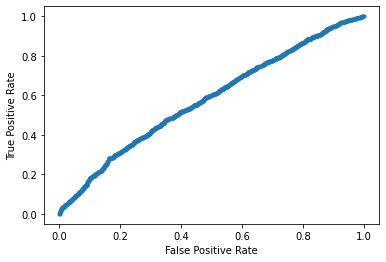

Accuracy: 57.50% Precision: 67.40% Recall: 64.86%
F1: 66.10% MCC: 0.0920
AUPRC: 70.55% AUROC: 58.07%
 accuracy [57.49669749009247]
 precision [67.40064446831364]
 recall [64.85788113695091]
 F1 [66.10481959441664]
 MCC [0.09201341664815249]
 AUPRC [70.54829897510227]
 AUROC [58.07130648169818]
2023-03-28 11:48:24.898855

Training # 2 5
2023-03-28 11:48:24.899013
2023-03-28 11:48:24.899056
Discriminator ZERO -1
Train 1:0 487:281 63.41%
Computed class weights: {0: 1.3665480427046264, 1: 0.7885010266940452}
Valid 1:0 1912:1094 63.61%
FIT
2023-03-28 11:48:25.941398


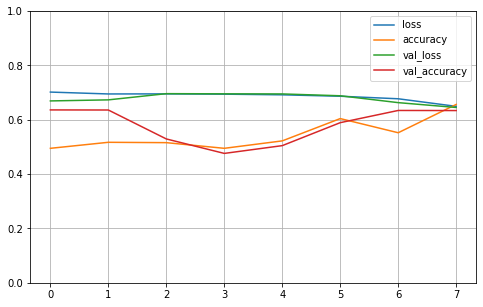


2023-03-28 11:48:37.189640

Testing # 2 5
2023-03-28 11:48:37.189738
2023-03-28 11:48:37.189773
PREDICT
2023-03-28 11:48:37.934960
Test 1:0 1912:1094 63.61%
Predict 1:0 2085:921 69.36%
Test sizes (3006, 4997) (3006,)
Range of scores: 0.12769538 to 0.90779966
Score threshold 0.5
Confusion matrix
 [[ 457  637]
 [ 464 1448]]
Normalized matrix
 [[0.15202927 0.21190951]
 [0.15435795 0.48170326]]


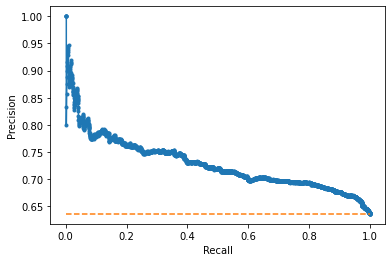

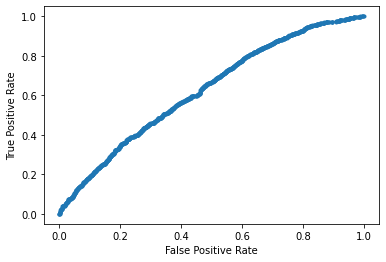

Accuracy: 63.37% Precision: 69.45% Recall: 75.73%
F1: 72.45% MCC: 0.1827
AUPRC: 72.90% AUROC: 62.70%
 accuracy [63.37325349301397]
 precision [69.4484412470024]
 recall [75.73221757322176]
 F1 [72.45434075556669]
 MCC [0.18270268854502672]
 AUPRC [72.89761778183113]
 AUROC [62.700456273473414]
2023-03-28 11:48:39.224796


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.18% std 2.14
 precision mean 66.24% std 1.71
 recall mean 79.96% std 9.13
 F1 mean 72.18% std 3.17
 MCC mean 0.10% std 0.05
 AUPRC mean 67.72% std 2.38
 AUROC mean 56.28% std 2.97
 accuracy [[61.95974925767074], [62.58300132802125], [63.11448366875618], [61.962987442167886], [60.18024032042724], [60.105855110817075], [57.959048877146635], [63.068747924277645], [57.49669749009247], [63.37325349301397]]
 precision [[65.16], [65.86054010479646], [65.4302103250478], [68.12327506899723], [66.3013698630137], [66.35773864689527], [64.50603486812696], [63.78304153793341], [67.40064446831364], [69.4484412470024]]
 recall [[85.24332810047096], [85.37095088819227], [88.88311688311688], [76.37957710159876], [76.14053487152596], [74.89539748953975], [75.07804370447451], [97.02349869451697], [64.85788113695091], [75.73221757322176]]
 F1 [[73.86080253910677], [74.35722411831627], [75.37444933920705], [72.01556041818624], [70.88113253600196], [70.36855036855036], [69.39168069247415],